In [ ]:
#! kaggle datasets download uraninjo/augmented-alzheimer-mri-datasetm

###https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2

**In this NoteBook**, a convolutional neural network (CNN)-based Alzheimer MRI images classification algorithm is developed using **ResNet152V2** architecture, to detect **"Mild Demented"**, **"Moderate Demented"**, **"Non Demented"** and **"Very Mild Demented"** in patient's MRI.

In [ ]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import applications
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import plot_loss_curves

--2023-08-11 10:18:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-11 10:18:31 (95.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



#  Uploading the Data

In [ ]:
########### splitting data ############
%pip install split-folders
import splitfolders
splitfolders.ratio('..///content/drive/MyDrive/ResnetDataset/AugmentedDataSet', output="input", seed=1345, ratio=(0.7,0.3,0))

SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)
data_dir = '..///content/input'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

Copying files: 34004 files [11:05, 51.07 files/s] 


**Mathematical model for Hyper param tuning**

In [ ]:
import numpy as np
from scipy.optimize import minimize
# Objective Function
def objective_function(params, target_accuracy):
    epochs, iterations, batch_size, dropout_factor = params
    return -target_accuracy / (epochs * iterations * batch_size * (1 - dropout_factor))
# Example optimization
def optimize_params(target_accuracy, input_size):
    # Bounds for each parameter: (epochs, iterations, batch_size, dropout_factor)
    bounds = [(1, 100), (1, 1000), (1, 128), (0.0, 0.99)]
    # Initial guess for the parameters: (epochs, iterations, batch_size, dropout_factor)
    initial_guess = [10, 100, 64, 0.1]
    # Perform optimization using scipy's minimize function
    result = minimize(objective_function, initial_guess, args=(target_accuracy,),
                      bounds=bounds, method='SLSQP')
    # Get the optimized parameters
    epochs, iterations, batch_size, dropout_factor = result.x

    return epochs, iterations, batch_size, dropout_factor
if __name__ == "__main__":
    # Example input size and target accuracy
    input_size = 34004
    target_accuracy = 0.99
    # Optimize parameters
    epochs, iterations, batch_size, dropout_factor = optimize_params(target_accuracy, input_size)
    print("Optimized Parameters:")
    print(f"Number of Epochs: {int(epochs)}")
    print(f"Number of Iterations per Epoch: {int(iterations)}")
    print(f"Batch Size: {int(batch_size)}")
    print(f"Dropout Factor: {dropout_factor:.2f}")


Optimized Parameters:
Number of Epochs: 10
Number of Iterations per Epoch: 100
Batch Size: 64
Dropout Factor: 0.10


# Defining Categories

In [ ]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

### Calculating the number of images in each category in training data

In [ ]:
for category in CATEGORIES:
  print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

MildDemented 6286 images
ModerateDemented 4524 images
NonDemented 6720 images
VeryMildDemented 6272 images


# Creating Train and Validation DataFrame

In [ ]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(23802, 3)

In [ ]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=4) ###### train size from 0.2 to 0.3

In [ ]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [ ]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(16661, 3)
(7141, 3)


In [ ]:
train.head()

,file,category,category_id
0,train/ModerateDemented/3e12ddc1-f2d1-410c-800d...,ModerateDemented,1
1,train/ModerateDemented/89af17ca-db81-455f-bcb2...,ModerateDemented,1
2,train/VeryMildDemented/91af7b6c-c6fd-41e2-9624...,VeryMildDemented,3
3,train/NonDemented/3763eee2-a883-4975-8920-0169...,NonDemented,2
4,train/VeryMildDemented/ba427ba6-12f5-4988-abf4...,VeryMildDemented,3


In [ ]:
validation.head()

,file,category,category_id
0,train/NonDemented/988e5a08-e369-4d98-9aa8-6c66...,NonDemented,2
1,train/NonDemented/3b2bccf4-fd34-4500-ab82-f02d...,NonDemented,2
2,train/NonDemented/9bc95045-b9b0-4baf-a1b4-6823...,NonDemented,2
3,train/MildDemented/4f13aaf5-057a-4788-a010-ce5...,MildDemented,0
4,train/NonDemented/1f537988-05df-4e91-af19-71b2...,NonDemented,2


# Creating Test DataFrame

In [ ]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(10201, 3)

# Demonstrating Example Images

In [ ]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

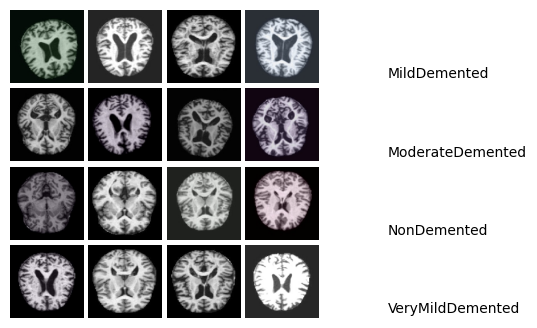

In [ ]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1

plt.show();

# Keras ImageDataGenerator

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 16661 validated image filenames belonging to 4 classes.
Found 7141 validated image filenames belonging to 4 classes.


In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 10201 validated image filenames belonging to 4 classes.


## Early Stopping

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

###Creating CallBacks   ===> 8-8-2023

In [ ]:
# Hyperparameter Tuning ===>   8-8-2023
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Creating Model based on ResNet152V2

In [ ]:
def create_model():

    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )

    for layers in resnet_model.layers[:100]:
        layers.trainable = False
    for layers in resnet_model.layers[100:]:
        layers.trainable = True

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    optimizer = tf.keras.optimizers.Adam()
    #optimizer = tf.keras.optimizers.RMSprop()
    #res_model.compile(loss='categorical_crossentropy', optimizer='ٌadam', metrics=['accuracy'])
    res_model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return res_model

In [ ]:
res_model = create_model()

234545216/234545216 [==============================] - 2s 0us/step


In [ ]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Model Architecture Visualization
tf.keras.utils.plot_model(res_model, to_file='resnet152v2.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

# Training the Model

In [ ]:
history = res_model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=callbacks,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
521/521 [==============================] - 264s 305ms/step - loss: 0.8045 - accuracy: 0.6307 - val_loss: 113.9183 - val_accuracy: 0.2323 - lr: 0.0010
Epoch 2/50
521/521 [==============================] - 161s 308ms/step - loss: 0.5225 - accuracy: 0.7773 - val_loss: 0.7068 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 3/50
521/521 [==============================] - 151s 290ms/step - loss: 0.3605 - accuracy: 0.8554 - val_loss: 0.6413 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 4/50
521/521 [==============================] - 147s 282ms/step - loss: 0.2774 - accuracy: 0.8918 - val_loss: 0.7597 - val_accuracy: 0.8114 - lr: 0.0010
Epoch 5/50
521/521 [==============================] - 155s 297ms/step - loss: 0.1975 - accuracy: 0.9272 - val_loss: 0.5218 - val_accuracy: 0.8405 - lr: 0.0010
Epoch 6/50
521/521 [==============================] - 147s 282ms/step - loss: 0.1508 - accuracy: 0.9448 - val_loss: 4.2415 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 7/50
521/521 [========================

# Plotting the history of model

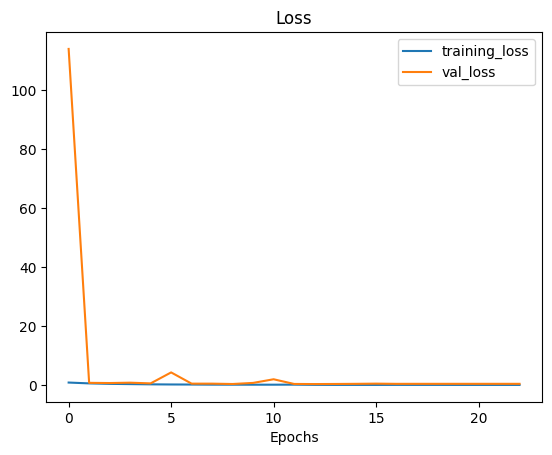

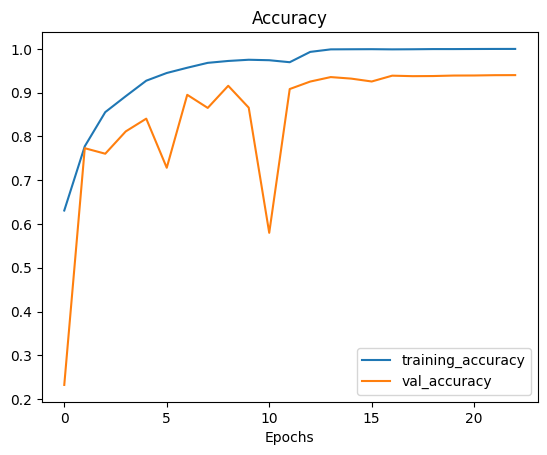

In [ ]:
plot_loss_curves(history)

# Evaluation

In [ ]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

224/224 [==============================] - 19s 85ms/step - loss: 0.2897 - accuracy: 0.9252

Train loss: 0.29
Train Accuracy: 92.52 %


In [ ]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

319/319 [==============================] - 28s 88ms/step - loss: 0.2945 - accuracy: 0.9294

Test loss: 0.29 
Test Accuracy: 92.94 %


In [ ]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

319/319 [==============================] - 30s 79ms/step


,precision,recall,f1-score,support
MildDemented,0.954036,0.947661,0.950838,2694.000000
ModerateDemented,0.996914,0.999484,0.998197,1939.000000
NonDemented,0.953704,0.858333,0.903509,2880.000000
VeryMildDemented,0.842422,0.936756,0.887088,2688.000000
accuracy,0.929419,0.929419,0.929419,0.929419
macro avg,0.936769,0.935559,0.934908,10201.000000
weighted avg,0.932682,0.929419,0.929679,10201.000000


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['support'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['precision'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['recall'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['f1-score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['support'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['precision', 'recall'], ['recall', 'f1-score'], ['f1-score', 'support']]], **{})
chart

####Create the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
# Set the number of classes for your task
num_classes = 4

# Generate predictions on the test dataset
y_true = test_generator.classes
y_pred = res_model.predict(test_generator)

# Get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()


In [ ]:
# Evaluate the Model on Test Data   ======>9-8-2023
test_loss, test_accuracy = res_model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


319/319 [==============================] - 27s 84ms/step - loss: 0.2945 - accuracy: 0.9294
Test Loss: 0.2945440113544464
Test Accuracy: 0.929418683052063


In [ ]:
# Evaluate the Model on Train Data   ======>9-8-2023
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

224/224 [==============================] - 19s 83ms/step - loss: 0.2897 - accuracy: 0.9252

Train loss: 0.29
Train Accuracy: 92.52 %


"\n# Compute and Plot ROC Curves\ny_true = test_generator.classes\ny_pred = res_model.predict(test_generator)\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\nfor i in range(4):\n    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\nplt.subplot(1, 2, 2)\nplt.plot([0, 1], [0, 1], 'k--')\nfor i in range(4):\n    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('ROC Curves')\nplt.legend()\n\nplt.tight_layout()\nplt.show()\n"

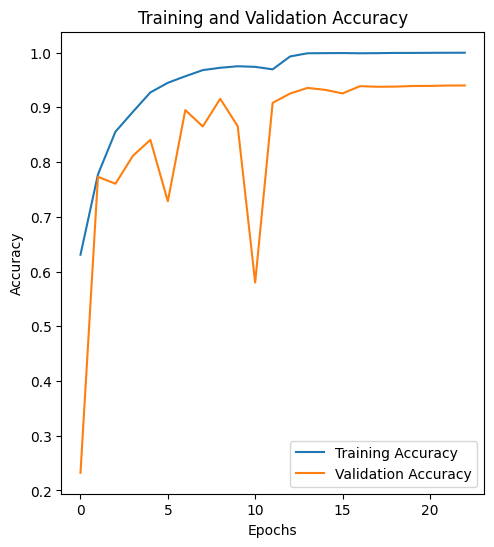

In [ ]:
# Metrics Visualization    =====>9-8-2023
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
'''
# Compute and Plot ROC Curves
y_true = test_generator.classes
y_pred = res_model.predict(test_generator)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'k--')
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

plt.tight_layout()
plt.show()
'''

In [ ]:
res_model.save('Resnet_model.h5')

In [ ]:
!zip -r dowinloadme.zip Resnet_model.h5

  adding: Resnet_model.h5 (deflated 10%)
